### Imports

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import validation_curve
%matplotlib inline

### Structuring data

In [2]:
df = pd.read_pickle('full_no_budgets_w_sentiment.pkl')

### TEMPORARY
#df = df.drop_duplicates(subset = ['title', 'year'])

#budgets = pd.read_pickle('budgets_clean.pkl')
#budgets = budgets.drop('releaseDate', axis = 1)
#df = df.merge(budgets, on = ['title', 'year'])
### TEMPORARY

def possible_values(df, colname):
    out = set([])
    for row in df[colname]:
        for g in row:
            out.add(g)
    return out

def dummies_from_nested_categories(df, colname):
    possible_valuess = possible_values(df, colname)
    
    def clean(s):
        return s.replace(' ', '').replace('&', '').lower()
    
    for pos in possible_valuess:
        df['d_' + clean(pos)] = df[colname].apply(lambda x: pos in x).astype(int)
    return df


# Create dummies for mpaaRating
dummies = pd.get_dummies(df['mpaaRating'])
df = pd.concat([df, dummies], axis = 1)

# Create dummies for genres
dummies_from_nested_categories(df, 'genres')

# Create dummies for studio
dummies = pd.get_dummies(df['studio'])
df = pd.concat([df, dummies], axis = 1)

# Create dummies for actors
#dummies_from_nested_categories(df, 'actors')
#dummies_from_nested_categories(df, 'directors')

data = df.drop(['actors', 'mpaaRating', 'synopsis', 'title', 'tomatoIcon', 'releaseDate', 'genres', 'directors', \
                'studio', 'tomatoCount', 'audienceCount', 'year', 'titleType', \
                'isAdult', 'numVotes', 'boRank', 'studioAcronym', 'totalTheaters', \
                'boOpening', 'openingTheaters', 'sentimentAfter', 'numCommentsAfter', 'positiveWordsAfter'], axis = 1)

data_wo = data.copy()
data_wo = data_wo.drop(['sentimentBefore', 'numCommentsBefore', 'positiveWordsBefore'], axis = 1)

def get_float(string):
    try:
        return float(string)
    except:
        return None

items = ['tomatoMeter', 'audienceScore', 'runtime', 'boWorldwide']
for item in items:
    data[item] = data[item].apply(get_float)
    #print(item)
    #print(data.shape)

data = data.dropna(subset = items)

In [ ]:
# Temporary
# def get_top_actors(lst):
#     count = 0
#     for item in lst:
#         if item in top_500:
#             count += 1
#     return count

# def get_top_directors(lst):
#     count = 0
#     for item in lst:
#         if item in top_100:
#             count += 1
#     return count

# actors = pd.read_pickle('actors.pkl')
# directors = pd.read_pickle('directors.pkl')

# top_500 = actors.iloc[:500]['actor'].tolist()
# top_100 = directors.iloc[:100]['director'].tolist()

# data['topActors'] = df['actors'].apply(get_top_actors)
# data['topDirectors'] = df['directors'].apply(get_top_directors)

### Setup for ML

In [3]:
train, test = train_test_split(data, test_size = 0.25)

y_train = train[['tomatoMeter', 'audienceScore', 'averageRating', 'boWorldwide']]
y_train['boWorldwide'] = np.log(y_train['boWorldwide'])
y_test = test[['tomatoMeter', 'audienceScore', 'averageRating', 'boWorldwide']]
y_test['boWorldwide'] = np.log(y_test['boWorldwide'])

X_train = train.drop(['tomatoMeter', 'audienceScore', 'averageRating', 'boWorldwide'], axis = 1)
X_test = test.drop(['tomatoMeter', 'audienceScore', 'averageRating', 'boWorldwide'], axis = 1)

C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Linear regression

In [4]:
lregs = []

i = 1
for target in y_train:
    lreg = LinearRegression()
    lreg.fit(X_train, y_train[target])

    print(target + ':', mean_squared_error(y_test[target], lreg.predict(X_test)), r2_score(y_test[target], lreg.predict(X_test)))
    lregs.append(lreg)

tomatoMeter: 582297756151776.6 -768725213966.7607
audienceScore: 31427967980845.152 -85859521500.45923
averageRating: 429259479064.39655 -445092158969.0723
boWorldwide: 8899704374668.555 -1022341826447.849


### Lasso

In [125]:
pipe = make_pipeline(StandardScaler(), Lasso(random_state = 1))

gs_lassos = []
for target in y_train:
    gs_lasso = GridSearchCV(estimator = pipe, param_grid = {'lasso__alpha': np.logspace(-4, 4, 12)}, \
                      scoring = 'neg_mean_squared_error', n_jobs = -1, iid = False, cv = 10, verbose = 0)
    gs_lasso.fit(X_train, y_train[target])

    print(target + ':', mean_squared_error(y_test[target], gs_lasso.best_estimator_.predict(X_test)), r2_score(y_test[target], gs_lasso.best_estimator_.predict(X_test)))
    gs_lassos.append(gs_lasso)

C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


tomatoMeter: 617.7288096988972 0.18450018672910518


C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


audienceScore: 276.22121788185797 0.24537846002830033


C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


averageRating: 0.7262667203205553 0.2469458723657083
boWorldwide: 2.9283044908128053 0.6636148757865428


C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Coefficients

In [142]:
print(gs_lassos[2].best_estimator_.steps[1][1].coef_[3])
print(gs_lassos[3].best_estimator_.steps[1][1].coef_[3])

0.010973595511342846
0.0


### Validation curves

C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


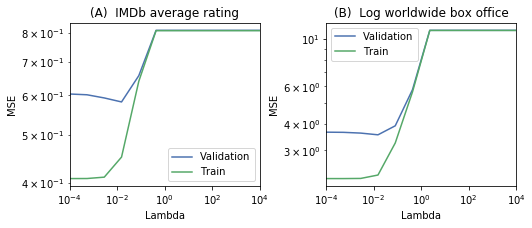

In [126]:
plt.style.use('seaborn-deep')

fig, axes = plt.subplots(1, 2, figsize = (8, 3))

lasso_audience_val = pd.DataFrame()
lasso_audience_val['Validation'] = -gs_lassos[2].cv_results_['mean_test_score']
lasso_audience_val['Train'] = -gs_lassos[2].cv_results_['mean_train_score']
lasso_audience_val['Lambda'] = np.logspace(-4, 4, 12)
lasso_audience_val = lasso_audience_val.set_index('Lambda')
lasso_audience_val.plot(logx = True, logy = True, ax = axes[0])

lasso_bo_val = pd.DataFrame()
lasso_bo_val['Validation'] = -gs_lassos[3].cv_results_['mean_test_score']
lasso_bo_val['Train'] = -gs_lassos[3].cv_results_['mean_train_score']
lasso_bo_val['Lambda'] = np.logspace(-4, 4, 12)
lasso_bo_val = lasso_bo_val.set_index('Lambda')
lasso_bo_val.plot(logx = True, logy = True, ax = axes[1])

axes[0].set_ylabel('MSE')
axes[1].set_ylabel('MSE')

axes[0].set_title('(A)  IMDb average rating')
axes[1].set_title('(B)  Log worldwide box office')

plt.subplots_adjust(wspace = 0.35)
plt.subplots_adjust(hspace = 0.5)

plt.savefig('validation-curves.pdf', bbox_inches = 'tight')

### Elastic net

In [19]:
gs_nets = []

for target in y_train: 
    pipe = make_pipeline(ElasticNet(random_state = 1))
    gs_net = GridSearchCV(estimator = pipe, param_grid = {'elasticnet__alpha': np.logspace(-4, 4, 12), \
                      'elasticnet__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}, \
                      scoring = 'neg_mean_squared_error', n_jobs = -1, iid = False, cv = 10, verbose = 0)
    gs_net.fit(X_train, y_train[target])
    
    print(target + ':', mean_squared_error(y_test[target], gs_net.best_estimator_.predict(X_test)), r2_score(y_test[target], gs_net.best_estimator_.predict(X_test)))
    
    gs_nets.append(gs_net)

tomatoMeter: 609.204829094204 0.1957531904458013


C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


audienceScore: 276.47120580681934 0.24469550643641003


C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


averageRating: 0.7014693021912763 0.27265791114491167
boWorldwide: 2.881796659650782 0.6689574016787165


C:\Users\Jacob\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Random shit

In [ ]:
test['predicted'] = gs.predict(X_test)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
import seaborn as sns
%matplotlib inline

sns.regplot('audienceScore', 'predicted', ci = None, data = test)

In [ ]:
for item in X_train.columns:
    print(item)

In [ ]:
X_train